In [4]:
import json
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dense, Embedding,  TimeDistributed
from tensorflow.keras.utils import to_categorical
import zipfile
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras import backend as K

In [5]:
np.random.seed(1234567890)

In [6]:
# word embedding with GloVe: load embedding as a dict
def load_embedding(filename_embedding,vocabulary,dim=300):
    embedding = dict()
    with open(filename_embedding,'r', encoding='utf8') as file:
        token = '##padding_token##'
        embedding[token] = dict()
        embedding[token]['vector'] = np.asarray(np.random.rand(dim), dtype='float32')
        embedding[token]['token_id'] = int(0)
        token_id = 1
        for line in tqdm(file):
            parts = line.split()
            token = parts[0]
            if token in vocabulary:
                embedding[token] = dict()
                embedding[token]['vector'] = np.asarray(parts[1:], dtype='float32')
                embedding[token]['token_id'] = int(token_id)
                token_id += 1
        # add embedding for unknown tokens
        token = '##unknown_token##'
        embedding[token] = dict()
        embedding[token]['vector'] = np.asarray(np.random.rand(dim), dtype='float32')
        embedding[token]['token_id'] = int(token_id)
        
    return embedding

In [7]:
def convert_tokens_labels_list_to_ids_list(tokens_list, labels_list,embedding, max_seq_length,labelclass_to_id):
    token_ids_list, label_ids_list = [], []
    n_tags = len(list(labelclass_to_id.keys()))
    for index in tqdm(range(len(tokens_list)), desc="Converting tokens & labels to ids "):
        tokens = tokens_list[index]
        labels = labels_list[index]   
        token_ids = []
        for token in tokens:
            if token not in embedding.keys():
                token = '##unknown_token##'
            token_ids.append(embedding[token]['token_id'])
        label_ids = [labelclass_to_id[label] for label in labels]
    
        # Zero-pad up to the sequence length.
        while len(token_ids) < max_seq_length:
            token_ids.append(0)
            label_ids.append(0)
        token_ids_list.append(token_ids)
        label_ids_list.append(label_ids)
        
    return (
        np.array(token_ids_list),
        to_categorical(np.array(label_ids_list), num_classes=n_tags),
    )



In [22]:
# import data
# specify the type of information which shall be extracted
#extraction_of = 'contexts'
extraction_of = 'sentiments'
#extraction_of = 'aspects'

#sentiment, aspect oder modifier -> diese drei braucht man
#extraktion von polarität nicht gefragt


# specify filenames in the next line
if extraction_of in ['contexts']:
    filename = r'data_laptop_ctxt.json'
elif extraction_of in ['sentiments','aspects']:
    filename = r'data_laptop_absa.json'

## in this example, we use the glove word embeddings as input for the neural network
## download glove.42B.300d.txt from http://nlp.stanford.edu/data/glove.42B.300d.zip
filename_embedding_zip = r'glove.42B.300d.zip' # folder of downloaded glove zip file
## specify folder where to store the glove embeddings
filepath_embedding = filename_embedding_zip.replace('.zip','')
## unzip and save glove to a folder manually or with the next lines
if not os.path.exists(filepath_embedding):
    with zipfile.ZipFile(filename_embedding_zip,"r") as zip_ref:
        zip_ref.extractall(filepath_embedding)
os.listdir(filepath_embedding)[0]
filename_embedding = filepath_embedding + '/' + os.listdir(filepath_embedding)[0]


with open(filename,'r', encoding='utf8') as infile:
    example_data = json.load(infile)


In [9]:
for i,(k,v) in enumerate(example_data.items()):
    #print(v.get("tokens"))
    tokens = v.get('tokens')
    tokens = [token.lower() for token in tokens]
    example_data[k]['tokens'] = tokens
    #key is txtname


### TRAIN TEST SPLIT

In [63]:
# split 85 15 in train and test tokens
#hier die ratio angeben
train_test_ratio = 0.95
len_dataset = len(example_data) -1

split_size = len_dataset * train_test_ratio
#split_size -> die anzahl an train datensätzen, rest ist test
print(split_size)

#hier wird dann anhand der ratio entschieden, ob der aktuelle satz zu train oder test gehört
train_tokens = []
test_tokens = []
for i,(k,v) in  enumerate(example_data.items()):
    if i < split_size: 
      train_tokens.append(v['tokens']) 
    else:
      test_tokens.append(v['tokens'])



2945.0


---
Ob man union oder inner join nutzt macht echt fast kein unterschied

## ALL USER REVIEWS AS OWN SENTENCE
- for that we need to insert each train token array the number of user who reviewed it

In [48]:
# split 85 15 in train and test tokens
#hier die ratio angeben
train_test_ratio = 0.95
len_dataset = len(example_data) -1

split_size = len_dataset * train_test_ratio
#split_size -> die anzahl an train datensätzen, rest ist test

#hier wird dann anhand der ratio entschieden, ob der aktuelle satz zu train oder test gehört
train_tokens = []
test_tokens = []
for i,(k,v) in  enumerate(example_data.items()):
    curr_users = [s for s in v.keys() if s != "tokens"]
    insertMul = len(curr_users)
    for doTimes in range(insertMul):
        if i < split_size: 
          train_tokens.append(v['tokens']) 
        else:
          test_tokens.append(v['tokens'])


433
8424


In [49]:
# this should be chagend: start
# this should be chagend: end
train_labels = list()
test_labels = list()
train_labels_uncertainty = list()
for d_idx,(k,v) in enumerate(example_data.items()):
    curr_users = [s for s in v.keys() if s !='tokens']         
    #jetzt jeden user durchgehen und dessen labels anschauen -> wenn irgendwas außer "O", dann 
    #den oben erstellten array an dieser stelle mit dessen label ersetzen
    for usr in curr_users:
        #print(usr)
        #print(v[usr][extraction_of])
        if d_idx < split_size:
          #davor v[curr_users[0]][extraction_of], jetzt merged_label
          train_labels.append(v[usr][extraction_of])
        else:
          test_labels.append(v[usr][extraction_of])


In [51]:
print(len(train_labels))
print(len(test_labels))

print(len(train_tokens))
print(len(test_tokens))


8424
433
8424
433


## UNION on users
- always use the sentiment labeling of every user, even if only 1 out of n users labeled the token as sentiment 

In [66]:
# this should be chagend: start
# this should be chagend: end
train_labels = list()
test_labels = list()
train_labels_uncertainty = list()
for d_idx,(k,v) in enumerate(example_data.items()):
    curr_users = [s for s in v.keys() if s !='tokens']
    
    # UNION: ein leeres array erzeugen und mit "O" auffüllen
    merged_label = []
    for i in range(len(v["tokens"])):
        #now we have an label array with only O s
            merged_label.insert(i, "O")
            
    #jetzt jeden user durchgehen und dessen labels anschauen -> wenn irgendwas außer "O", dann 
    #den oben erstellten array an dieser stelle mit dessen label ersetzen
    for usr in curr_users:
        #print(usr)
        #print(v[usr][extraction_of])
        for i,element in enumerate(v[usr][extraction_of]):
                if(element != "O"):
                    del merged_label[i]
                    merged_label.insert(i, element)
    #print("merged to: " + str(merged_label))
    if d_idx < split_size:
      #davor v[curr_users[0]][extraction_of], jetzt merged_label
      train_labels.append(merged_label)
    else:
      test_labels.append(merged_label)



## INNER JOIN on users

- only iff every user labeled the token the same way we use the labeled value, else we use O instead

In [65]:
# this should be chagend: start
# this should be chagend: end
train_labels = list()
test_labels = list()
train_labels_uncertainty = list()
for d_idx,(k,v) in enumerate(example_data.items()):
    curr_users = [s for s in v.keys() if s !='tokens']
    merged_label = []
    for token_idx in range(len(v["tokens"])):
        #print("token "+str(token_idx))
        matching = True
        #init on value of first user
        holder = v[curr_users[0]][extraction_of][token_idx]
        #only if all users have the same value, we insert the value
        for user_idx in range(len(curr_users)):
            #print("holder: "+holder)
            #print("current choice "+ str(v[curr_users[user_idx]][extraction_of][token_idx]))
            if not v[curr_users[user_idx]][extraction_of][token_idx] == holder:
                matching = False
        #means all users had the same labeling, so we can insert it
        if matching:
            merged_label.insert(token_idx, v[curr_users[0]][extraction_of][token_idx])
        else:
            #otherwise insert O
            merged_label.insert(token_idx, "O")
    #print("merged list")
    #print(merged_label)
    if d_idx < split_size:
      #davor v[curr_users[0]][extraction_of], jetzt merged_label
      train_labels.append(merged_label)
    else:
      test_labels.append(merged_label)



### Overview over TOKEN in train and test dataset

In [67]:
print("train test ratio "+str(train_test_ratio))
print("train data review count: "+str(len(train_labels)))
print("test data review count: "+str(len(test_labels)))
sum_train_tokens = 0
train_0_count = 0
train_B_S_count = 0
train_I_S_count = 0
train_analysis = {"0":0, "B_S": 0, "I_S": 0}

sum_test_tokens = 0
test_analysis = {"0":0, "B_S": 0, "I_S": 0}

#train analysis
for i in range(len(train_labels)):
    sum_train_tokens+=len(train_labels[i])
    for tok in range(len(train_labels[i])):
        token = train_labels[i][tok]
        if token == "O":
            train_analysis["0"] += 1
        elif token == "B_S":
            train_analysis["B_S"] += 1
        else:
            train_analysis["I_S"] += 1

#test analysis
for i in range(len(test_labels)):
    sum_test_tokens+=len(test_labels[i])
    for tok in range(len(test_labels[i])):
        token = test_labels[i][tok]
        if token == "O":
            test_analysis["0"] += 1
        elif token == "B_S":
            test_analysis["B_S"] += 1
        else:
            test_analysis["I_S"] += 1
print("train token count: "+str(sum_train_tokens))
print("test token count: "+str(sum_test_tokens))
print("train details: "+str(train_analysis))
print("test details: "+str(test_analysis))

train test ratio 0.95
train data review count: 2945
test data review count: 156
train token count: 51491
test token count: 2860
train details: {'0': 43278, 'B_S': 4807, 'I_S': 3406}
test details: {'0': 2430, 'B_S': 255, 'I_S': 175}


### to get an idea of the data we use we can run this snippet

In [68]:
for idx in range(0,3):
    print(idx)
    print("labels "+ str(train_labels[idx]))
    print("tokens "+str(train_tokens[idx]))

0
labels ['O', 'O', 'B_S', 'O']
tokens ['Computer', 'works', 'great', '.']
1
labels ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_S', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B_S', 'I_S', 'O']
tokens ['Bough', 'this', 'for', 'the', 'google', 'goodies', 'offers', 'for', 'the', 'holidays', 'but', 'when', 'i', 'go', 'to', 'redeem', 'the', 'offers', 'from', 'the', 'google', 'website', ',', 'it', 'says', 'that', 'this', "doesn't", 'have', 'the', 'right', '"', 'code', '"', 'to', 'get', 'the', 'drive', 'storage', '.', 'sending', 'back', '.']
2
labels ['O', 'O', 'O', 'O', 'O', 'B_S', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
tokens ['I', 'am', 'surprised', 'by', 'how', 'well', 'this', 'unit', 'is', 'made', 'and', 'performs', '.']


In [69]:
# generate vocabulary,token ids and embeddings for vocabulary
vocabulary = set(['##unknown_token##','##padding_token##'])
for v in example_data.values():
    vocabulary.update(set(v['tokens']))
vocabulary = list(vocabulary)
vocabulary.sort()
filename_rel_embedding = filename_embedding.replace('.txt','_rel.pkl')
if not os.path.exists(filename_rel_embedding):
    embedding = load_embedding(filename_embedding, vocabulary)
    pickle.dump(embedding,open(filename_rel_embedding,'wb'))
else:
    embedding = pickle.load(open(filename_rel_embedding,'rb'))
vocab_size = len (vocabulary)
embed_size = list(embedding.values())[0]['vector'].shape[0]
embedding_vectors = np.zeros((vocab_size, embed_size))
for v in embedding.values():
    vector = v['vector']
    token_id = v['token_id']
    embedding_vectors[token_id] = vector

all_labelclasses = set()
for row in train_labels:
    all_labelclasses.update(row)
all_labelclasses=list(all_labelclasses)
all_labelclasses.sort()


labelclass_to_id = dict(zip(all_labelclasses,list(range(len(all_labelclasses)))))

n_tags = len(list(labelclass_to_id.keys()))


max_seq_length = 100

# Create datasets (Only take up to max_seq_length words for memory)
train_tokens = [t[0:max_seq_length] for t in train_tokens]
test_tokens = [t[0:max_seq_length] for t in test_tokens]
train_labels = [t[0:max_seq_length] for t in train_labels]
test_labels = [t[0:max_seq_length] for t in test_labels]

# Convert data to Input format for neural network
x_train, y_train = convert_tokens_labels_list_to_ids_list(train_tokens, train_labels, embedding, max_seq_length,labelclass_to_id)
x_test, y_test = convert_tokens_labels_list_to_ids_list(test_tokens, test_labels, embedding, max_seq_length,labelclass_to_id)


Converting tokens & labels to ids : 100%|██████████| 156/156 [00:00<00:00, 39645.63it/s]


In [70]:
## better metrics

In [71]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [72]:
sample_weight = np.ones(shape=(len(y_train),))


In [73]:
# neural network model in keras
# see keras documentation for functions of different layers and structure of networks.

# the following two layers should not be changed.
input_layer = Input(shape=(max_seq_length,))
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_vectors], input_length=max_seq_length, trainable= False)(input_layer)

# here, attention models have to be implemented in this model
# ...

# this last layer can/should be modified
output_layer = TimeDistributed(Dense(n_tags, activation="softmax"))(embedding_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["categorical_accuracy", "accuracy", f1_m,precision_m, recall_m])
model.summary()

# fit model on train data
history = model.fit(x_train, y_train,
          batch_size=32,
          #validation_split = 0.2,
          verbose = 1,
          validation_data=(x_test, y_test),
          shuffle = True,
          epochs=50)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 300)          1694400   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 100, 3)            903       
Total params: 1,695,303
Trainable params: 903
Non-trainable params: 1,694,400
_________________________________________________________________
Epoch 1/50
93/93 [==============================] - 0s 4ms/step - loss: 0.2121 - categorical_accuracy: 0.9210 - accuracy: 0.9210 - f1_m: 0.9157 - precision_m: 0.9552 - recall_m: 0.8828 - val_loss: 0.1246 - val_categorical_accuracy: 0.9646 - val_accuracy: 0.9646 - val_f1_m: 0.9654 - val_precision_m: 0.9763 - val_recall_m: 0.9547
Epoch 2/50
93/93 [=======================

### GIVEN EVAL
- scheme provided by university

In [74]:
## evaluation
# predict labels of test data
y_test_pred_prob = model.predict(x_test)
y_test_pred_sparse = y_test_pred_prob.argmax(axis=-1)
y_test_pred = to_categorical(np.array(y_test_pred_sparse), num_classes=n_tags)

# compute confusion matrix
conf_matrix = np.zeros((n_tags, n_tags))
for i,tokens in enumerate(test_tokens):
    for j,_ in enumerate(tokens):
        class_true = y_test[i,j].argmax()
        class_pred = y_test_pred[i,j].argmax()
        conf_matrix[class_true,class_pred] += 1
names_rows = list(s+'_true' for s in labelclass_to_id.keys())
names_columns = list(s+'_pred' for s in labelclass_to_id.keys())
conf_matrix = pd.DataFrame(data=conf_matrix,index=names_rows,columns=names_columns)
display(conf_matrix)

# compute final evaluation measures
precision_per_class = np.zeros((n_tags,))
recall_per_class = np.zeros((n_tags,))
for i in range(n_tags):
    
    print("check gt 0")
    print(conf_matrix.values[i,i])
    print("")
    if conf_matrix.values[i,i] > 0:
        print("CLASS = "+str(i))
        precision_per_class[i] = conf_matrix.values[i,i]/sum(conf_matrix.values[:,i])
        print("precision")
        print(precision_per_class[i])
        recall_per_class[i] = conf_matrix.values[i,i]/sum(conf_matrix.values[i,:])
        print("recall")
        print(recall_per_class[i])
        print("f1")
        f1_class = 2*(precision_per_class[i]*recall_per_class[i])/(precision_per_class[i]+recall_per_class[i])
        print(f1_class)
    else:
        print("no (0) precision or recall for class "+str(i))
precision = np.mean(precision_per_class)
recall = np.mean(recall_per_class)
f1 = 2*(precision*recall)/(precision+recall)
print()
print('Precision: '+str(precision))
print('Recall: '+str(recall))
print('F1-measure: '+str(f1))

print("\n")
print(history.history.keys())

,B_S_pred,I_S_pred,O_pred
B_S_true,88.0,1.0,166.0
I_S_true,17.0,5.0,153.0
O_true,33.0,4.0,2393.0


check gt 0
88.0

CLASS = 0
precision
0.6376811594202898
recall
0.34509803921568627
f1
0.44783715012722647
check gt 0
5.0

CLASS = 1
precision
0.5
recall
0.02857142857142857
f1
0.05405405405405405
check gt 0
2393.0

CLASS = 2
precision
0.8823746312684366
recall
0.9847736625514403
f1
0.9307662388175807

Precision: 0.6733519302295754
Recall: 0.45281437677951836
F1-measure: 0.5414891792491335


dict_keys(['loss', 'categorical_accuracy', 'accuracy', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_categorical_accuracy', 'val_accuracy', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


### OWN EVAL

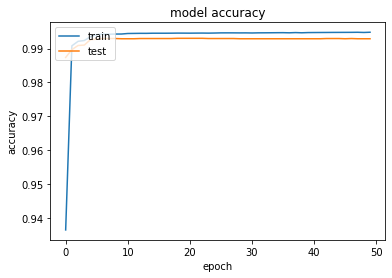

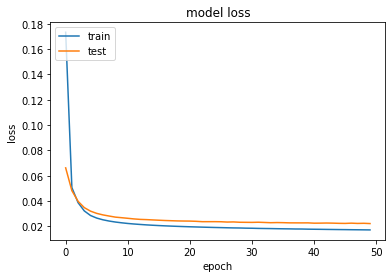

In [21]:
#this eval only works, if we use validation_split = 0.2 as additional parameter for model.fit()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
